# RBA Selected Tables

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-Up</a></span><ul class="toc-item"><li><span><a href="#Some-useful-constants" data-toc-modified-id="Some-useful-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some useful constants</a></span></li><li><span><a href="#List-available-data-tables-...-if-needed" data-toc-modified-id="List-available-data-tables-...-if-needed-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>List available data tables ... if needed</a></span></li><li><span><a href="#Clear-cache-if-necessary" data-toc-modified-id="Clear-cache-if-necessary-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Clear cache if necessary</a></span></li><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Utility functions</a></span></li></ul></li><li><span><a href="#Monetary-Policy---Official-Cash-Rate" data-toc-modified-id="Monetary-Policy---Official-Cash-Rate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monetary Policy - Official Cash Rate</a></span></li><li><span><a href="#Key-market-interest-rates" data-toc-modified-id="Key-market-interest-rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Key market interest rates</a></span></li><li><span><a href="#Australian-Government-Bonds---daily-rates" data-toc-modified-id="Australian-Government-Bonds---daily-rates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Australian Government Bonds - daily rates</a></span></li><li><span><a href="#Money-supply-and-the-velocity-of-money" data-toc-modified-id="Money-supply-and-the-velocity-of-money-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Money supply and the velocity of money</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Watermark</a></span></li></ul></div>

## Set-Up

In [1]:
# usual data science imports
import pandas as pd
import matplotlib.pyplot as plt

# syste imports
from pathlib import Path

# local imports
import rba_common
from abs_common import (
    get_ABS_meta_and_data,
    get_fs_constants,
    recalibrate_series,
)
from finalise_plot import finalise_plot

### Some useful constants

In [2]:
TODAY = pd.Timestamp('today')

# multi-time-period charts
RECENCY_PERIOD = 5 # years
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)

V_RECENCY_PERIOD = 275 # days
V_RECENT = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

TEN_YEARS = TODAY - pd.DateOffset(years=10)

# Where to put the charts
CHART_DIR = "./charts/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

# plotting stuff
plt.style.use('fivethirtyeight')
SOURCE = "Source: RBA"

### List available data tables ... if needed

In [3]:
if False: 
    rba_common.get_data_table_labels()

### Clear cache if necessary

In [4]:
if False:
    rba_common.clear_cache()

### Utility functions

In [5]:
def print_last_date(df: pd.DataFrame) -> None:
    print('Last date', df.index[-1].date())

## Monetary Policy - Official Cash Rate

In [6]:
# get the data
a2 = rba_common.get_data('Monetary Policy Changes – A2')
a2_meta, a2_data = a2 if a2 is not None else (None, None)
print_last_date(a2_data)

Using cached data for "Monetary Policy Changes – A2"
Last date 2022-11-02


In [7]:
# extract the cash rate series
target = 'New Cash Rate Target'
series_id = a2_meta[a2_meta.Title == target].index[0]
series = a2_data[series_id]

# remove some early target ranges
series = series[series.index >= pd.Timestamp("1990-08-02")].astype(float)

# update the series to today
if TODAY > series.index[-1]:
    last = series.iloc[-1]
    series[TODAY] = last
    series = series.sort_index()
                        
# plot full series and recent
count=0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = series if start is None else series[series.index >= start].copy()
    tag = "" if start is None else f'-recent{count}'
    if start is not None and start < data.index[0]:
        data[start] = data.iloc[0]
        data = data.sort_index()
    count += 1
        
    # plot
    ax = data.plot(drawstyle='steps-post', c='#dd0000', lw=2)
    ax.margins(0.025, 0.025)
    title = "RBA Official Cash Rate"
    finalise_plot(
        ax, title, "Per cent", tag, CHART_DIR,
        rfooter=f'{SOURCE} A2',
        concise_dates=True,
        #show=True,
    )

## Key market interest rates

In [8]:
# get the dataset
_ = rba_common.get_data('Interest Rates and Yields – Money Market – Daily – F1')
f1_meta, f1_data = _ if _ is not None else (None, None)
print_last_date(f1_data)

Using cached data for "Interest Rates and Yields – Money Market – Daily – F1"
Last date 2022-11-18


In [9]:
# get the specific data we want, for the very recent past
wanted = ['Cash Rate Target',
          'Interbank Overnight Cash Rate',
          'EOD 1-month BABs/NCDs',
          '1-month OIS',
          '1-month Treasury Note',]
series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
plotable_data = (
    f1_data[series_ids]
    .pipe(lambda x: x[x.index>=V_RECENT])
    .rename({old:neu for old, neu in zip(series_ids, wanted)}, axis=1)
    .dropna(how='all', axis=1)
    .dropna(how='all', axis=0)
)

# And plot
ax = plotable_data.plot(drawstyle='steps-post', lw=2)
ax.margins(0.025, 0.025)
title = "Key Australian Market Interest Rates"
ax.legend(title=None, loc='best')

finalise_plot(
    ax, title, "Per cent", "", CHART_DIR,
    rfooter=f'{SOURCE} F1 Daily',
    concise_dates=True,
    #show=True,
)

## Australian Government Bonds - daily rates

In [10]:
# get the dataset
_ = rba_common.get_data('Capital Market Yields – Government Bonds – Daily – F2')
f2_meta, f2_data = _ if _ is not None else (None, None)
print_last_date(f2_data)

Using cached data for "Capital Market Yields – Government Bonds – Daily – F2"
Last date 2022-11-17


In [11]:
# get the specific data we want
plotable = f2_meta[f2_meta.Title.str.contains('Australian') &
                   f2_meta.Title.str.contains('year') ]
plotable_labels = (
    plotable
    .Title
    .str.replace('Australian Government ', '')
)
plotable_data = f2_data[plotable_labels.index]
plotable_data.columns = plotable_labels

# plot full series and recent
count = 0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = plotable_data if start is None else plotable_data[plotable_data.index >= start].copy()
    tag = "" if start is None else f'-recent{count}'
    lw = 2 if start == V_RECENT else 1
    count += 1
        
    # plot
    ax = data.plot(drawstyle='steps-post', lw=lw)
    ax.margins(0.025, 0.025)
    title = "Capital Market Yields - Australian Government Bonds"
    
    # remove legend title
    #handles, labels = ax.get_legend_handles_labels()
    ax.legend(title=None, loc='best')
    
    # finalise
    finalise_plot(
        ax, title, "Per cent per annum", tag, CHART_DIR,
        rfooter=f'{SOURCE} F2 Daily',
        concise_dates=True,
        #show=True,
    )    

## Money supply and the velocity of money

According to the Quantity Theory of Money:

$$ MV=PT $$

Where ($M$) is money supply, ($V$) is the velocity of circulation (the number of times 
money changes hands), ($P$) is the average price level, and ($T$) is the volume of transactions of goods and services. Of note: $PT$ is the same as nominal GDP. Therefore:

$$V=\frac{nGDP}{M}$$


In [12]:
# Get DataFrame for the M1 and M3 money supply
_ = rba_common.get_data('Monetary Aggregates – D3')
d3_meta, d3_data = _ if _ is not None else (None, None)
print_last_date(d3_data)

Using cached data for "Monetary Aggregates – D3"
Last date 2022-09-30


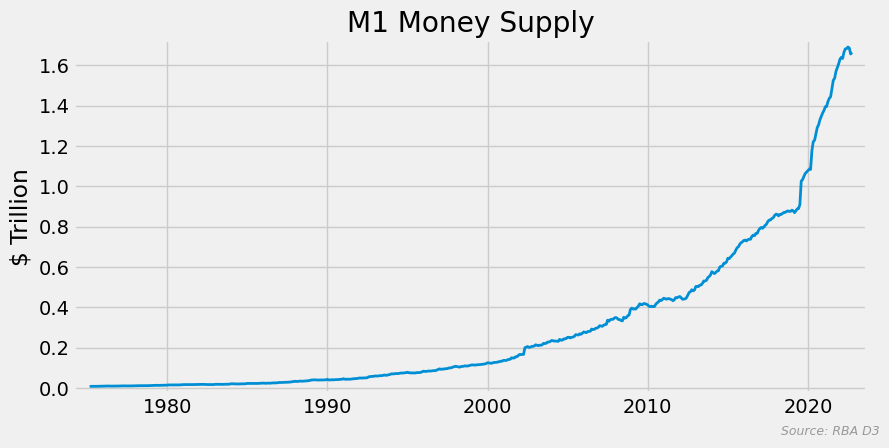

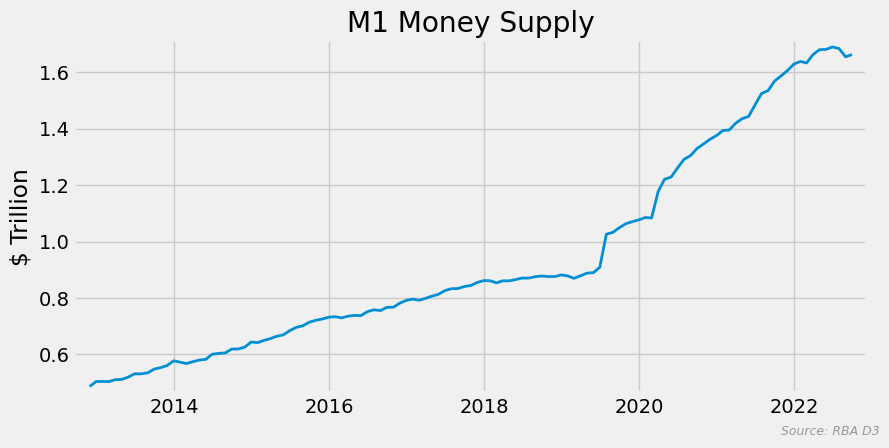

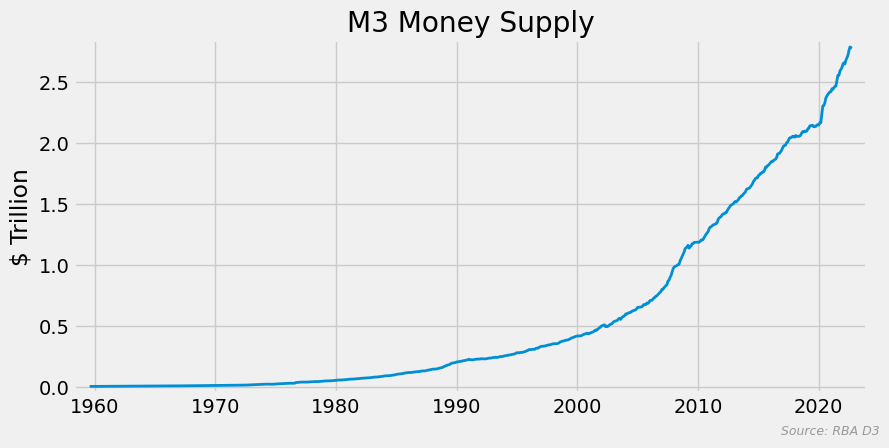

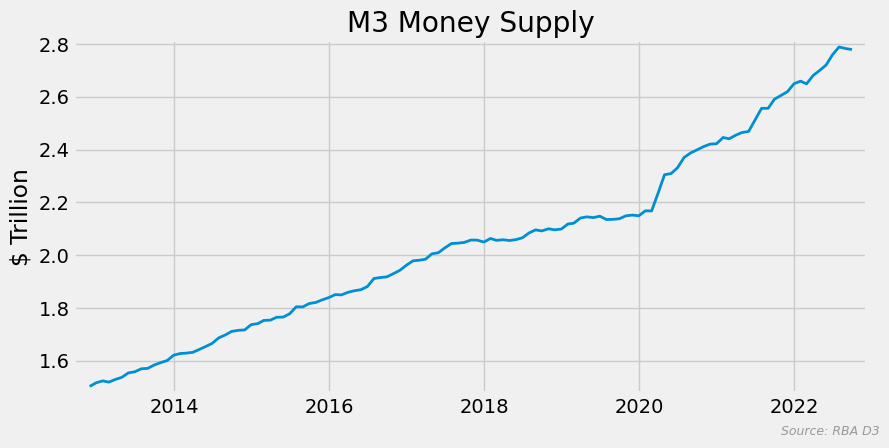

In [13]:
# plot Money Supply
to_get = ['M1', 'M3']
gotten = {t:d3_data[d3_meta[d3_meta.Title == t].index[0]] for t in to_get}
m_units = {t:d3_meta[d3_meta['Title'] == t].Units[0] for t in to_get}

for title, series in gotten.items():
    series = series.dropna().astype(float)
    series, m_unit = recalibrate_series(series, m_units[title])
    
    for start in None, TEN_YEARS:
        plotable = series if start is None else series[series.index >= start]
        tag = "" if start is None else f'recent'
        
        fig, ax = plt.subplots()
        ax.plot(plotable.index, plotable, lw=2)
        finalise_plot(
            ax, f'{title} Money Supply', m_unit, tag, CHART_DIR,
            rfooter=f'{SOURCE} D3',
            concise_dates=True,
            dont_close=True,
            show=True,
        )

        ax.set_yscale('log')
        finalise_plot(
            ax, f'{title} Money Supply', 
            f'{m_unit} (log scale)', f'{tag}-log', CHART_DIR,
            rfooter=f'{SOURCE} D3',
            concise_dates=True,
            show=True,
        )

In [14]:
# get nominal GDP from the ABS National Accounts
catalogue_id = '5206'
abs_dict = get_ABS_meta_and_data(catalogue_id)
source, _, META_DATA = get_fs_constants(catalogue_id)
meta = abs_dict[META_DATA]

table = '3' # GDP expenditure in current prices
data = abs_dict[table]

series_type = 'Seasonally Adjusted'
data_item = 'GROSS DOMESTIC PRODUCT ;'
selected = meta[
    (meta.Table == table)
    & (meta['Series Type'] == series_type)
    & meta['Data Item Description'].str.contains(data_item)
]
assert len(selected) == 1
units = selected.Unit.iloc[0]
series_id = selected['Series ID'].iloc[0]
yearly_nom_gdp = data[series_id].rolling(4).sum().dropna() # sum to annual nominal GDP
yearly_nom_gdp, units = recalibrate_series(yearly_nom_gdp, units)
print(units, '\n', yearly_nom_gdp)

Retrieving zip-file from cache ./ABS_CACHE/_statistics_economy_national-accounts_australian-national-accounts-national-income-expenditure-and-product_jun-2022_All_time_series_workbooks.zip ...
$ Trillions 
 Series ID
1960-06-01    0.016604
1960-09-01    0.017031
1960-12-01    0.017370
1961-03-01    0.017623
1961-06-01    0.017568
                ...   
2021-06-01    2.067494
2021-09-01    2.122331
2021-12-01    2.175179
2022-03-01    2.230605
2022-06-01    2.296586
Name: A2304418T, Length: 249, dtype: float64


## Watermark

In [15]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Nov 18 2022 09:59:10

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.6.0

matplotlib: 3.6.2
pandas    : 1.5.1

Watermark: 2.3.1

